# Intro

# Libraries

In [211]:
import gc
import logging
import os
import shutil

import matplotlib.pyplot as plt
import mlflow as mlf
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as st
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp

import src.algorithms.advantages as adv
import src.algorithms.algo_utils as autil
import src.algorithms.dummy as dummy
import src.algorithms.policy_gradient.tf2.ac as ac
import src.algorithms.policy_gradient.tf2.ppo as ppo
import src.algorithms.policy_gradient.tf2.vpg as vpg
import src.models.base_models.tf2.policy_nets as policy_nets
import src.models.base_models.tf2.value_nets as vnets
import src.utils as util
from src.envs.resource_allocation_env import DiscreteProjectsEnv, DiscreteProjectOptimizerAgent

In [2]:
from importlib import reload

In [3]:
dummy = reload(dummy)

In [212]:
log = logging.getLogger()
log.setLevel(logging.INFO)
std_handler = logging.StreamHandler(sys.stdout)
log.addHandler(std_handler)

In [213]:
mlf.autolog()
mlf.tensorflow.autolog()
mlf.keras.autolog()

2022/04/02 11:35:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/04/02 11:35:19 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2022/04/02 11:35:19 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\mlflow\utils\autologging_utils\__init__.py:410: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


# Hard env

In [139]:
ENV_SIZE = 300

In [214]:
env_hard = DiscreteProjectsEnv(
    start_resource=100,
    start_cash=100,
    upkeep_cost=-1,
    min_payout=-0.5,
    max_payout=1.5,
    payout_mean=1.0,
    payout_std=0.5,
    size=ENV_SIZE,
    distrib_prob=tfp.distributions.TruncatedNormal(0.3, 0.2, 0.0, 1.0),
    balance_is_reward=False,
    stochastic=True)

s_dim = env_hard.observation_space.shape[0]
a_dim = env_hard.action_space.n

C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


<AxesSubplot:>

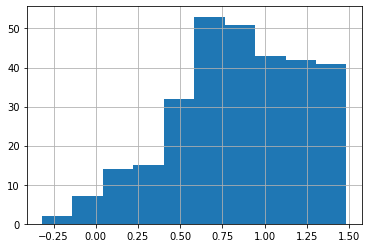

In [215]:
env_hard.projects.proj_1_payouts.hist()

<AxesSubplot:>

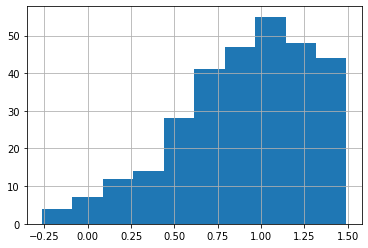

In [216]:
env_hard.projects.proj_2_payouts.hist()

## Agents

#### PPO

In [252]:
krs.backend.clear_session()
print(gc.collect())

s_dim = env_hard.observation_space.shape[0]
a_dim = env_hard.action_space.n

initializer = krs.initializers.HeNormal()
policy_net_ppo = policy_nets.DiscretePolicyNet(a_dim, [128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_ppo = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

policy_opt = krs.optimizers.Adam(0.0003, clipnorm=1.)
value_opt = krs.optimizers.Adam(0.0003, clipnorm=1.)

agent_ppo = ppo.PPO(
    policy_net_ppo,
    value_net_ppo,
    policy_opt,
    value_opt,
    adv.GAE,
    n_agents=5,
    clipping_eps=0.2,
    entropy_coef=0.01)

825


In [219]:
x = krs.layers.Input((1, 8), name='State input')
policy_net_viz = krs.models.Model(inputs=[x], outputs=policy_net_ppo.call(x))

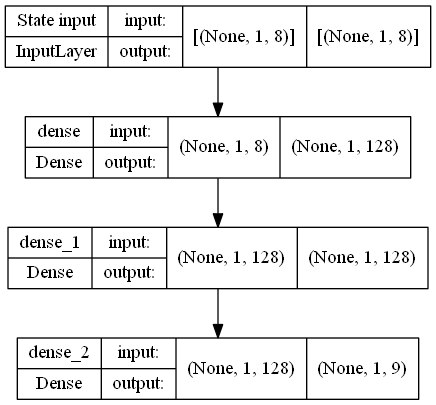

In [220]:
krs.utils.plot_model(policy_net_viz, show_shapes=True)

Model was constructed with shape (None, 8) for input KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None, 1, 8).
Model was constructed with shape (None, 8) for input KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None, 1, 8).


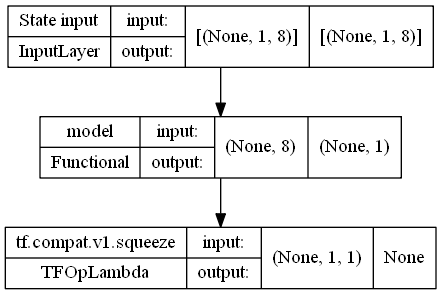

In [221]:
value_net_viz = krs.models.Model(inputs=[x], outputs=value_net_ppo.state_value(x))
krs.utils.plot_model(value_net_viz, show_shapes=True)

#### AC

In [262]:
policy_net_ac = policy_nets.DiscretePolicyNet(a_dim, [128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_ac = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

agent_ac = ac.ActorCrtic(
    policy_net_ac,
    value_net_ac,
    krs.optimizers.Adam(0.0003, clipnorm=1.),
    krs.optimizers.Adam(0.0003, clipnorm=1.),
    adv.GAE,
    entropy_coef=0.01)

#### VPG

In [270]:
policy_net_vpg = policy_nets.DiscretePolicyNet(a_dim, [128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_vpg = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

agent_vpg = vpg.VPG(
    policy_net_vpg,
    value_net_vpg,
    adv.GAE,
    policy_opt=krs.optimizers.Adam(0.0003, clipnorm=1.),
    value_opt=krs.optimizers.Adam(0.0003, clipnorm=1.),
    entropy_coef=0.01)

In [224]:
dummy_agent = DiscreteProjectOptimizerAgent(env_hard)

In [225]:
random_agent = dummy.DummyAgent(env_hard)

## Evaluate before training

In [253]:
ppo_scores_before = autil.evaluate_algorithm(agent_ppo, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [227]:
ac_scores_before = autil.evaluate_algorithm(agent_ac, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [271]:
vpg_scores_before = autil.evaluate_algorithm(agent_vpg, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [229]:
dummy_scores = autil.evaluate_algorithm(dummy_agent, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [230]:
random_scores = autil.evaluate_algorithm(random_agent, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

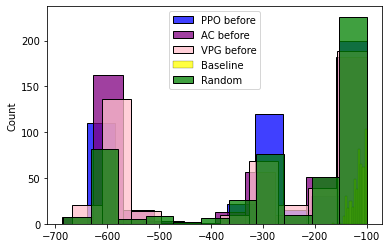

In [272]:
sns.histplot(ppo_scores_before, color='blue', label='PPO before')
sns.histplot(ac_scores_before, color='purple', label='AC before')
sns.histplot(vpg_scores_before, color='pink', label='VPG before')
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(random_scores, color='green', label='Random')
plt.legend()

## Train agent

In [232]:
EXPERIMENT_HARD = 'projects_env_hard'

In [233]:
experiment_id_hard = util.prepare_mlflow(EXPERIMENT_HARD)

#### Train PPO

In [254]:
env_hard.reset()
with mlf.start_run(experiment_id=experiment_id_hard, run_name='PPO hard'):
    ppo_scores_after = agent_ppo.train(env_hard, 3000, max_steps=ENV_SIZE, average_n_last=30, print_interval=10, epochs=5, batch_size=16, log=log, gamma=0.99, clip_action=False, max_train_sec=30 * 60)

Ep: 0/600  Rewards avg.: -480.600  Loss avg.: 0.733  Time passed: 0.002/30.000
Ep: 10/600  Rewards avg.: -245.363  Loss avg.: 0.645  Time passed: 0.097/30.000
Ep: 20/600  Rewards avg.: -208.380  Loss avg.: 0.755  Time passed: 0.191/30.000
Ep: 30/600  Rewards avg.: -181.523  Loss avg.: 0.763  Time passed: 0.268/30.000
Ep: 40/600  Rewards avg.: -172.403  Loss avg.: 0.691  Time passed: 0.378/30.000
Ep: 50/600  Rewards avg.: -191.366  Loss avg.: 0.796  Time passed: 0.518/30.000
Ep: 60/600  Rewards avg.: -200.516  Loss avg.: 0.783  Time passed: 0.703/30.000
Ep: 70/600  Rewards avg.: -172.132  Loss avg.: 0.756  Time passed: 0.909/30.000
Ep: 80/600  Rewards avg.: -142.917  Loss avg.: 0.751  Time passed: 1.089/30.000
Ep: 90/600  Rewards avg.: -137.991  Loss avg.: 0.814  Time passed: 1.211/30.000
Ep: 100/600  Rewards avg.: -172.701  Loss avg.: 0.802  Time passed: 1.334/30.000
Ep: 110/600  Rewards avg.: -167.418  Loss avg.: 1.004  Time passed: 1.460/30.000
Ep: 120/600  Rewards avg.: -148.124  Lo

#### Train AC

In [263]:
env_hard.reset()
with mlf.start_run(experiment_id=experiment_id_hard, run_name='AC hard'):
    ac_scores_after = agent_ac.train(
        env_hard,
        600,
        max_steps=ENV_SIZE,
        average_n_last=30,
        print_interval=10,
        log=log,
        gamma=0.99,
        clip_action=False,
        max_train_sec=15*60,
        n_steps=15)

Ep: 0/600  Rewards avg.: -300.000  Loss avg.: -0.019  Time passed: 0.001/15.000
Ep: 10/600  Rewards avg.: -264.659  Loss avg.: 0.422  Time passed: 0.005/15.000
Ep: 20/600  Rewards avg.: -283.692  Loss avg.: 0.602  Time passed: 0.010/15.000
Ep: 30/600  Rewards avg.: -278.490  Loss avg.: 0.607  Time passed: 0.016/15.000
Ep: 40/600  Rewards avg.: -258.851  Loss avg.: 0.629  Time passed: 0.023/15.000
Ep: 50/600  Rewards avg.: -237.189  Loss avg.: 0.542  Time passed: 0.029/15.000
Ep: 60/600  Rewards avg.: -240.234  Loss avg.: 0.409  Time passed: 0.035/15.000
Ep: 70/600  Rewards avg.: -233.987  Loss avg.: 0.500  Time passed: 0.043/15.000
Ep: 80/600  Rewards avg.: -208.549  Loss avg.: 0.621  Time passed: 0.056/15.000
Ep: 90/600  Rewards avg.: -172.950  Loss avg.: 0.564  Time passed: 0.086/15.000
Ep: 100/600  Rewards avg.: -152.335  Loss avg.: 0.607  Time passed: 0.113/15.000
Ep: 110/600  Rewards avg.: -152.391  Loss avg.: 0.733  Time passed: 0.129/15.000
Ep: 120/600  Rewards avg.: -139.352  L

#### Train VPG

In [273]:
env_hard.reset()
with mlf.start_run(experiment_id=experiment_id_hard, run_name='VPG hard'):
    vpg_scores_after = agent_vpg.train(
        env_hard,
        600,
        max_steps=ENV_SIZE,
        average_n_last=30,
        print_interval=10,
        log=log,
        gamma=0.99,
        clip_action=False,
        max_train_sec=15*60)

Ep: 0/600  Rewards avg.: nan  Loss avg.: 0.981  Time passed: 0.001/15.000


C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep: 10/600  Rewards avg.: -322.695  Loss avg.: 0.994  Time passed: 0.007/15.000
Ep: 20/600  Rewards avg.: -257.062  Loss avg.: 0.614  Time passed: 0.015/15.000
Ep: 30/600  Rewards avg.: -216.048  Loss avg.: 0.302  Time passed: 0.022/15.000
Ep: 40/600  Rewards avg.: -150.343  Loss avg.: -0.267  Time passed: 0.031/15.000
Ep: 50/600  Rewards avg.: -120.259  Loss avg.: -0.689  Time passed: 0.039/15.000
Ep: 60/600  Rewards avg.: -108.744  Loss avg.: -1.072  Time passed: 0.051/15.000
Ep: 70/600  Rewards avg.: -99.658  Loss avg.: -1.385  Time passed: 0.061/15.000
Ep: 80/600  Rewards avg.: -98.565  Loss avg.: -1.264  Time passed: 0.072/15.000
Ep: 90/600  Rewards avg.: -98.073  Loss avg.: -0.635  Time passed: 0.081/15.000
Ep: 100/600  Rewards avg.: -97.766  Loss avg.: 0.129  Time passed: 0.090/15.000
Ep: 110/600  Rewards avg.: -96.369  Loss avg.: 0.566  Time passed: 0.101/15.000
Ep: 120/600  Rewards avg.: -95.942  Loss avg.: 0.643  Time passed: 0.113/15.000
Ep: 130/600  Rewards avg.: -95.842  L

## Eval after train

In [53]:
results_dir = "discrete_env_results_hard"

In [54]:
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
    os.mkdir(results_dir)

## Compare results

In [264]:
ppo_eval_scores_after = autil.evaluate_algorithm(agent_ppo, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                 clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [265]:
ac_eval_scores_after_500 =  autil.evaluate_algorithm(agent_ac, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                     clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [274]:
vpg_eval_scores_after_500 =  autil.evaluate_algorithm(agent_vpg, env_hard, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                      clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

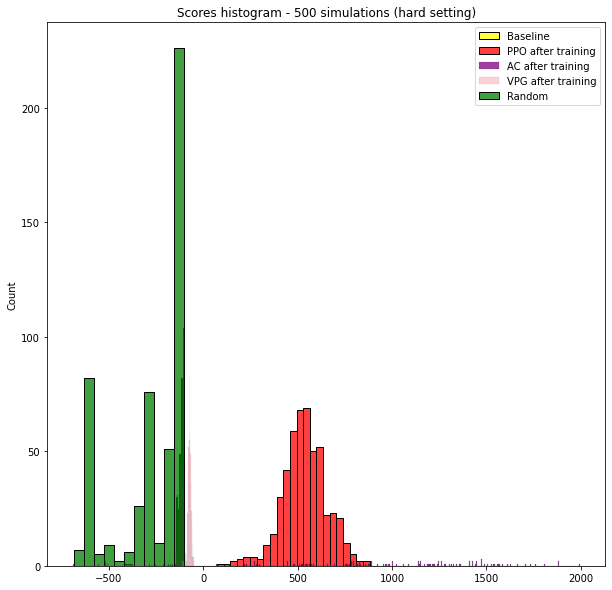

In [275]:
plt.figure(figsize=(10, 10))
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(ppo_eval_scores_after, color='red', label='PPO after training')
sns.histplot(ac_eval_scores_after_500, color='purple', label='AC after training')
sns.histplot(vpg_eval_scores_after_500, color='pink', label='VPG after training')
sns.histplot(random_scores, color='green', label='Random')
plt.title("Scores histogram - 500 simulations (hard setting)")
plt.legend()
plt.savefig(f"./{results_dir}/scores_histogram.png")

In [277]:
result_df = pd.DataFrame({
    'random': random_scores,
    'PPO after': ppo_eval_scores_after,
    'AC after': ac_eval_scores_after_500,
    'VPG after': vpg_eval_scores_after_500,
    'baseline': dummy_scores, })
result_df.describe()

,random,PPO after,AC after,VPG after,baseline
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-268.206995,529.444963,137.742610,-73.363941,-115.573343
std,185.855851,134.386761,531.493562,9.931531,12.073136
min,-685.000000,-419.083933,-690.970322,-110.000000,-166.802627
25%,-340.000000,465.911829,-120.953260,-78.141356,-122.369043
50%,-171.000000,532.573202,-107.305185,-72.109473,-113.268260
75%,-117.000000,606.613654,-100.268260,-67.830483,-105.607952
max,-100.000000,881.243317,1994.115927,-45.813581,-100.098790


In [278]:
result_df.to_csv(os.path.join(results_dir, "scores_hard_env.csv"), index=False)

In [279]:
stat, pval = st.levene(*[result_df[c] for c in result_df.columns])
pval.round(4)

0.0

In [280]:
st.kruskal(*[result_df[c] for c in result_df.columns])

KruskalResult(statistic=1675.1553264791305, pvalue=0.0)

In [281]:
melted_df = result_df.melt(var_name='model')
result = pg.welch_anova(melted_df, dv='value', between='model')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,model,4,1136.258731,3694.871566,0.0,0.532463


In [282]:
pairwise_test = pg.pairwise_gameshowell(melted_df, dv='value', between='model', effsize='cohen')
pairwise_test

,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,AC after,PPO after,137.742610,529.444963,-391.702354,24.517145,-15.976671,562.544217,0.001,-1.010453
1,AC after,VPG after,137.742610,-73.363941,211.106550,23.773264,8.879999,499.348471,0.001,0.561620
2,AC after,baseline,137.742610,-115.573343,253.315952,23.775246,10.654609,499.514961,0.001,0.673857
3,AC after,random,137.742610,-268.206995,405.949604,25.180461,16.121611,619.237876,0.001,1.019620
4,PPO after,VPG after,529.444963,-73.363941,602.808904,6.026348,100.028886,504.450509,0.001,6.326382
5,PPO after,baseline,529.444963,-115.573343,645.018306,6.034163,106.894410,507.054331,0.001,6.760596
6,PPO after,random,529.444963,-268.206995,797.651958,10.256920,77.767205,908.772524,0.001,4.918430
7,VPG after,baseline,-73.363941,-115.573343,42.209402,0.699137,60.373619,962.223621,0.001,3.818363
8,VPG after,random,-73.363941,-268.206995,194.843054,8.323585,23.408550,501.849751,0.001,1.480487
9,baseline,random,-115.573343,-268.206995,152.633652,8.329245,18.325029,503.211245,0.001,1.158977


In [283]:
pairwise_test.to_csv(os.path.join(results_dir, "pairwise_test_res_hard_env.csv"), index=False)

In [284]:
result.to_csv(os.path.join(results_dir, "welch_test_hard_env.csv"), index=False)